In [1]:
# -*- coding: utf8

from scipy import stats as ss
from sklearn import datasets

import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

plt.rcParams['figure.figsize']  = (18, 10)
plt.rcParams['axes.labelsize']  = 20
plt.rcParams['axes.titlesize']  = 20
plt.rcParams['legend.fontsize'] = 20
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['lines.linewidth'] = 4

In [2]:
plt.ion()
plt.style.use('seaborn-colorblind')
plt.rcParams['figure.figsize']  = (12, 8)

In [3]:
def despine(ax=None):
    if ax is None:
        ax = plt.gca()
    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')

## Aula 21 - Logística

Temos um conjunto de dados anônimos de aproximadamente 284 lances do jogador Lebron James. Como é comum em variáveis categóricas, representamos a variável dependente como 0 (errou a cesta) ou 1 (acertou a cesta). Esta será a nossa resposta que queremos prever. 

In [4]:
df = pd.read_csv('https://media.githubusercontent.com/media/icd-ufmg/material/master/aulas/21-Logistica/lebron.csv')
df.head()

,game_date,minute,opponent,action_type,shot_type,shot_distance,shot_made
0,20170415,10,IND,Driving Layup Shot,2PT Field Goal,0,0
1,20170415,11,IND,Driving Layup Shot,2PT Field Goal,0,1
2,20170415,14,IND,Layup Shot,2PT Field Goal,0,1
3,20170415,15,IND,Driving Layup Shot,2PT Field Goal,0,1
4,20170415,18,IND,Alley Oop Dunk Shot,2PT Field Goal,0,1


In [5]:
df.shape

(384, 7)

Vamos iniciar observando a quantidade de acertos por distância da cesta.

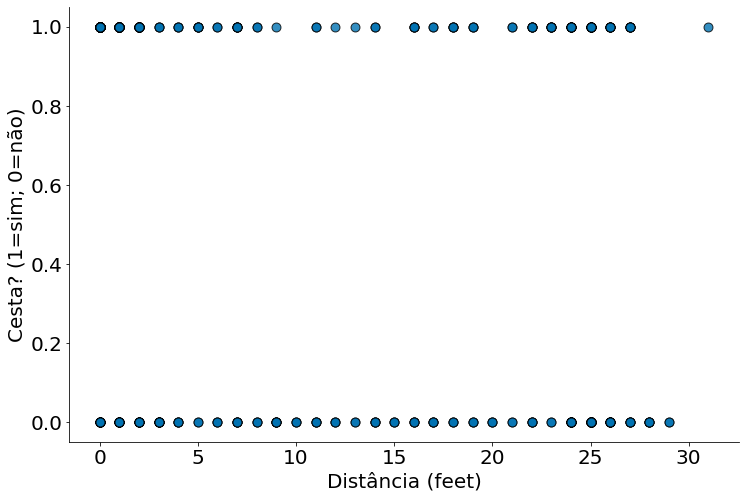

In [6]:
n = df.shape[0]
plt.scatter(df['shot_distance'],
            df['shot_made'],
            s=80, alpha=0.8, edgecolors='k')
plt.xlabel('Distância (feet)')
plt.ylabel('Cesta? (1=sim; 0=não)')
despine()

Adicionando algum ruído para melhorar o plot. Observe como os dados se concentram do lado esquerdo.

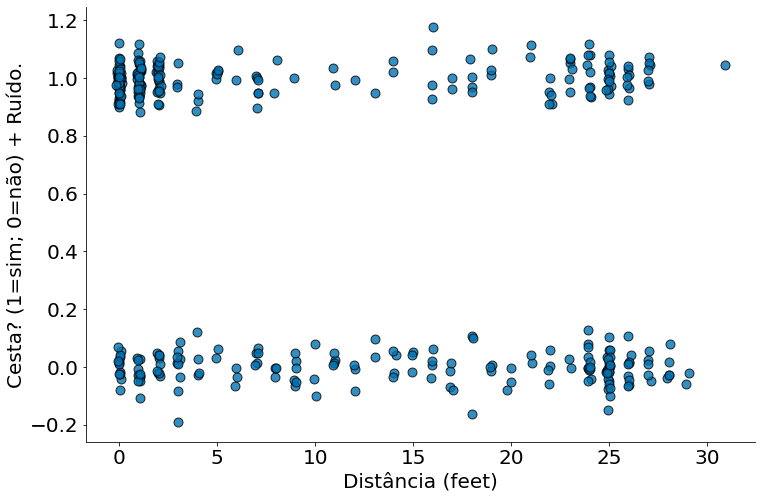

In [7]:
n = df.shape[0]
plt.scatter(df['shot_distance'] + np.random.normal(0, 0.05, size=n),
            df['shot_made'] + np.random.normal(0, 0.05, size=n),
            s=80, alpha=0.8, edgecolors='k')
plt.xlabel('Distância (feet)')
plt.ylabel('Cesta? (1=sim; 0=não) + Ruído.')
despine()

Como identificar quando Lebron acerta ou erra? Uma primeira tentativa óbvia é usar regressão linear e encontrar o melhor modelo. Observe como a mesma tenta capturar os locais de maior concentração de pontos.

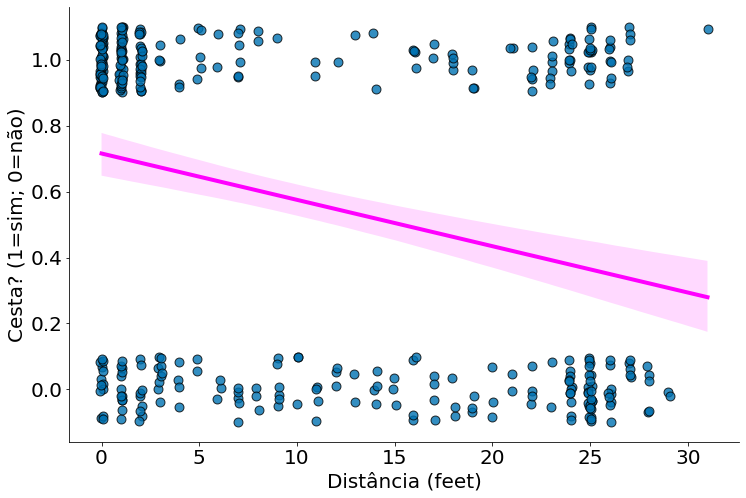

In [8]:
sns.regplot(x='shot_distance', y='shot_made', data=df, n_boot=10000,
            x_jitter=.1, y_jitter=.1,
            line_kws={'color':'magenta', 'lw':4},
            scatter_kws={'edgecolor':'k', 's':80, 'alpha':0.8})
plt.xlabel('Distância (feet)')
plt.ylabel('Cesta? (1=sim; 0=não)')
despine()

O resultado é uma curva com inclinação negativa.

In [9]:
ss.linregress(df['shot_distance'], df['shot_made'])

LinregressResult(slope=-0.014055196583349782, intercept=0.7154288863745248, rvalue=-0.29865301020530843, pvalue=2.3711855177639102e-09, stderr=0.002298007163935254)

Mas essa abordagem leva a alguns problemas imediatos:

* Gostaríamos que nossos resultados previstos fossem 0 ou 1. Tudo bem se eles estiverem entre 0 e 1, já que podemos interpretá-los como probabilidades - uma saída de 0,25 pode significar 25% de chance de ser um membro que paga. Mas as saídas do modelo linear podem ser números positivos enormes ou até números negativos, o que não fica claro como interpretar.

* O que gostaríamos, ao contrário, é que valores positivos grandes de $\mathbf{x_i}~ . \mathbf{\theta}$ (ou `np.dot(x_i,theta)`) correspondam a probabilidades próximas a 1 e que valores negativos grandes correspondam a probabilidades próximas a 0. Podemos conseguir isso aplicando outra função ao resultado.

## A Função Logística

No caso da regressão logística, a gente usa a função logística:

In [10]:
def sigmoid(X, theta):
    return 1.0 / (1.0 + np.exp(-X.dot(theta)))

À medida que sua entrada se torna grande e positiva, ela se aproxima e se aproxima de 1. À medida que sua entrada se torna grande e negativa, ela se aproxima e se aproxima de 0. Além disso, ela tem a propriedade conveniente que sua derivada é dada por:

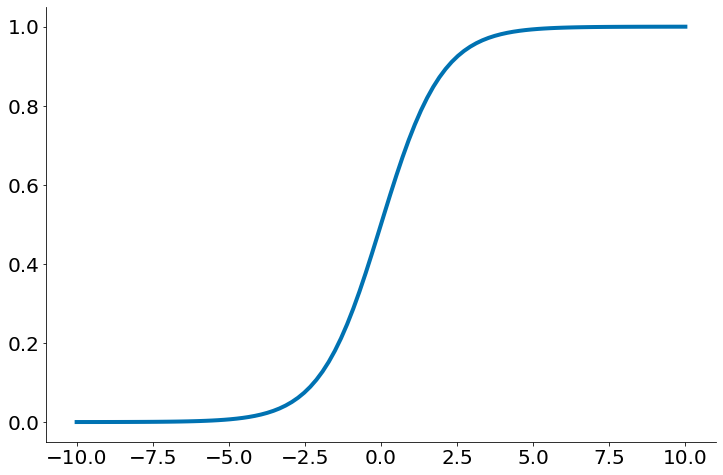

In [11]:
X = np.linspace(-10, 10, 100)[:, None] # vira um vetor coluna
y = sigmoid(X, theta=np.array([1]))
plt.plot(X, y)
despine()

A medida que sua entrada se torna grande e positiva, ela se aproxima e se aproxima de 1. À medida que sua entrada se torna grande e negativa, ela se aproxima e se aproxima de 0. Podemos inverter a mesma alterando o valor de theta.

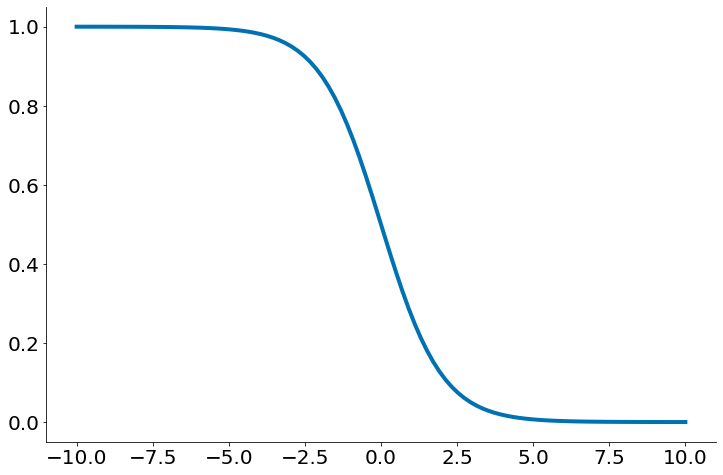

In [12]:
X = np.linspace(-10, 10, 100)[:, None] # vira um vetor coluna
y = sigmoid(X, theta=np.array([-1]))
plt.plot(X, y)
despine()

Além disso, ela tem a propriedade conveniente que sua derivada é dada por:

In [13]:
def logistic_prime(X, theta):
    return sigmoid(X, theta) * (1 - sigmoid(X, theta))

Oberseve a derivada em cada ponto.

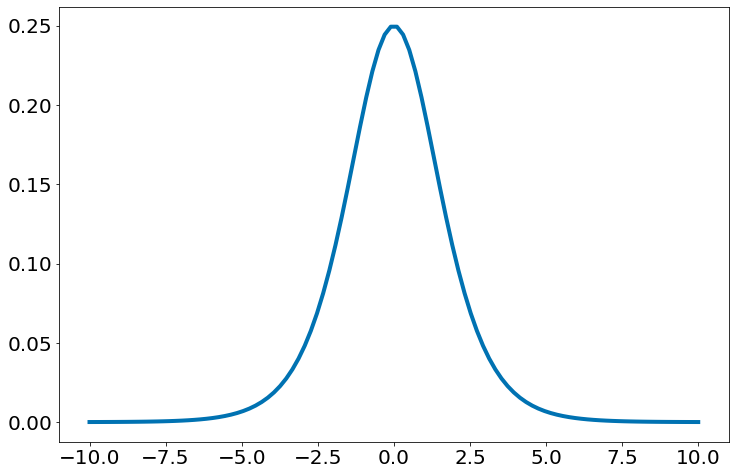

In [14]:
plt.plot(X, logistic_prime(X, np.array([1])))

Daqui a pouco vamos usar a mesma para ajustar um modelo:

$$y_i = f(x_i\theta) + \epsilon_i$$

onde $f$ é a função logística (`logistic`).

Note também que $x_i\theta$, para $j$ variáveis independentes, nada mais é que o modelo linear visto nas aulas anteriores, que é calculado e dado como entrada para a função logística:

$$x_i\theta = \theta_0 + \theta_1 x_1 + \cdots + \theta_j x_j$$

Lembre-se de que, para a regressão linear, ajustamos o modelo minimizando a soma dos erros quadrados, o que acaba escolhendo o $\theta$ que maximiza a probabilidade dos dados.

Aqui os dois não são equivalentes, por isso usaremos gradiente descendente para maximizar a verossimilhança diretamente. Isso significa que precisamos calcular a função de verossimilhança e seu gradiente.

Dado algum $\theta$, nosso modelo diz que cada $y_i$ deve ser igual a 1 com probabilidade $f(x_i\theta)$ e 0 com probabilidade $1 - f(x_i\theta)$.

Em particular, a PDF para $y_i$ pode ser escrita como:

$$p(y_i~|~x_i,\theta) = f(x_i\theta)^{y_i}(1-f(x_i\theta))^{1-y_i}$$

Se $y_i$ é $0$, isso é igual a:

$$1-f(x_i\theta)$$

e se $y_i$ é $1$, é igual a:

$$f(x_i\theta)$$

Acontece que é realmente mais simples maximizar o logaritmo da verossimilhança (*log likelihood*):

$$\log ll_{\theta}(y_i~|~x_i) = y_i \log f(x_i\theta) + (1-y_i) \log (1-f(x_i\theta))$$

Como o logaritmo é uma função estritamente crescente, qualquer $\theta$ que maximize o logaritmo da verossimilhança também maximiza a verossimilhança, e vice-versa.

## Cross Entropy

Ao invés de trabalhar na verossimilhança, vamos inverter a mesma (negar). Esta é a definição de cross entropy para a regressão logística. Nos slides da aula derivamos a equivalência entre as duas. [Slides](https://docs.google.com/presentation/d/1yGPETPe8o7PPOP6_CF38LHr3vpxgTEnF5LjP-1pkGIc/edit?usp=sharing).

$$L(\theta) = -n^{-1}\sum_i \big((1-y_i)\log_2(1-f_{\theta}(x_i)) + y_i\log_2(f_{\theta}(x_i))\big)$$

A equação acima é a cross-entropy média por observação.

In [15]:
def cross_entropy_one_sample(x_i, y_i, theta):
    # também podemos escrever y_i * np.log(sigmoid(np.dot(x_i, beta)))
    if y_i == 1:
        return -np.log(sigmoid(np.dot(x_i, theta)))
    else:
        return -np.log(1 - sigmoid(np.dot(x_i, theta)))

O clip abaixo limita os valores para 0.0001 e 0.9999, evita imprecisões numéricas. Ou seja, se o vetor tiver um valor 1.01 por erro numérico, corrigimos para 0.9999.

In [16]:
def cross_entropy_mean(X, y, theta):
    yp = y > 0.5
    logit = sigmoid(X, theta)
    logit = np.clip(logit, 0.00001, 0.99999)
    return -(yp * np.log(logit) + (1 - yp) * np.log(1 - logit)).mean()

A derivada da mesma tem uma forma similar ao da regressão linear. Veja a derivação nos [Slides](https://docs.google.com/presentation/d/1yGPETPe8o7PPOP6_CF38LHr3vpxgTEnF5LjP-1pkGIc/edit?usp=sharing). Partindo da derivada da logística acima, chegamos em:

$$
L'(\theta) = -n^{-1}\sum_i \big(-\frac{(1-y_i)f'_{\theta}(x_i)}{1- f_{\theta}(x_i)} + \frac{y_if'_{\theta}(x_i) }{f_{\theta}(x_i)}\big)
$$

Simplificando:

$$
L'(\theta) = -n^{-1}\sum_i \big(-\frac{(1-y_i)f'_{\theta}(x_i)}{1- f_{\theta}(x_i)} + \frac{y_if'_{\theta}(x_i) }{f_{\theta}(x_i)}\big) \\
L'(\theta) = -n^{-1}\sum_i \big(-\frac{(1-y_i)}{1- f_{\theta}(x_i)} + \frac{y_i}{f_{\theta}(x_i)}\big)f_{\theta}(x_i)(1-f_{\theta}(x_i)) \\
L'(\theta) = -n^{-1}\sum_i \big(-\frac{(1-y_i)}{1- f_{\theta}(x_i)} + \frac{y_i}{f_{\theta}(x_i)}\big)f_{\theta}(x_i)(1-f_{\theta}(x_i)) \\
L'(\theta) = -n^{-1}\sum_i (y_i - f_{\theta}(x_i)) x_i
$$

Escrevendo em forma vetorizada. Caso não entenda, veja o material da regressão linear múltipla.

In [17]:
def derivadas(theta, X, y):
    return -((y - sigmoid(X, theta)) * X.T).mean(axis=1)

Podemos otimizar por gradiente descendente.

In [18]:
def gd(X, y, lambda_=0.01, tol=0.0000001, max_iter=10000):
    theta = np.ones(X.shape[1])
    print('Iter {}; theta = '.format(0), theta)
    old_err = np.inf
    i = 0
    while True:
        # Computar as derivadas
        grad = derivadas(theta, X, y)
        # Atualizar
        theta_novo = theta - lambda_ * grad
        
        # Parar quando o erro convergir
        err = cross_entropy_mean(X, y, theta)
        if np.abs(old_err - err) <= tol:
            break
        theta = theta_novo
        old_err = err
        print('Iter {}; theta = {}; cross_e = {}'.format(i+1, theta, err))
        i += 1
        if i == max_iter:
            break
    return theta

Executando nos dados. Note o intercepto, necessário.

In [19]:
new_df = df[['shot_distance']].copy()
new_df['intercepto'] = 1
X = new_df[['intercepto', 'shot_distance']].values
y = df['shot_made'].values
X[:10]

array([[ 1,  0],
       [ 1,  0],
       [ 1,  0],
       [ 1,  0],
       [ 1,  0],
       [ 1,  0],
       [ 1,  7],
       [ 1, 23],
       [ 1, 25],
       [ 1, 11]])

In [20]:
y[:10]

array([0, 1, 1, 1, 1, 1, 1, 1, 1, 0])

In [21]:
theta = gd(X, y)

Iter 0; theta =  [1. 1.]
Iter 1; theta = [0.99639116 0.93815854]; cross_e = 3.8372185688014135
Iter 2; theta = [0.99280026 0.87634372]; cross_e = 3.7972328908301627
Iter 3; theta = [0.98922885 0.81455913]; cross_e = 3.7523457095542145
Iter 4; theta = [0.98567869 0.7528091 ]; cross_e = 3.701900424045673
Iter 5; theta = [0.98215177 0.69109896]; cross_e = 3.647864840031765
Iter 6; theta = [0.97865039 0.62943541]; cross_e = 3.583606296758237
Iter 7; theta = [0.97517726 0.56782707]; cross_e = 3.50879824690689
Iter 8; theta = [0.97173556 0.50628547]; cross_e = 3.417271400163878
Iter 9; theta = [0.96832919 0.44482658]; cross_e = 3.307931926255197
Iter 10; theta = [0.96496306 0.38347379]; cross_e = 3.1751856571604953
Iter 11; theta = [0.9616436  0.32226391]; cross_e = 2.9128724140347977
Iter 12; theta = [0.95837982 0.26126117]; cross_e = 2.5431525030105306
Iter 13; theta = [0.95518564 0.20059524]; cross_e = 2.1708964854025012
Iter 14; theta = [0.95208606 0.14057961]; cross_e = 1.80357973424099

Agora vamos pegar os valores maiores do que 0.5 como previsões.

In [22]:
previsoes = sigmoid(X, theta) > 0.5
print(previsoes)

[ True  True  True  True  True  True  True False False  True  True  True
  True  True  True  True  True  True  True False  True  True False  True
  True  True False  True  True  True  True False False  True  True  True
 False  True False  True False  True False False  True  True False  True
 False  True  True  True False False  True False False False False  True
  True  True  True  True False False False  True  True  True  True  True
  True  True  True  True  True  True  True  True  True False  True  True
  True  True  True  True  True  True False False  True  True  True  True
  True False False  True  True  True  True False  True False False  True
 False False  True  True False False  True  True  True  True  True False
 False False  True  True  True False False  True False  True  True False
  True  True False  True False  True False False  True False False False
  True False  True False False  True  True False  True  True False False
  True  True False False False False False False Fa

Vamos ver nosso acerto

In [23]:
print(previsoes == y)

[False  True  True  True  True  True  True False False False False  True
  True False False  True False False  True  True False  True False False
  True  True False  True  True False  True  True  True  True  True False
  True  True  True False False False False  True False  True False  True
  True False False False False  True  True False False  True  True  True
  True  True False  True False  True  True False  True  True False False
  True False False False  True  True  True  True  True  True  True  True
 False  True  True False False False False  True  True  True  True False
  True  True  True False False False  True False  True False  True False
 False False False  True False  True  True False  True False  True False
 False  True  True  True  True False False  True  True  True False  True
  True  True False False  True  True  True  True  True False  True False
  True  True  True  True False  True  True  True  True  True False  True
 False  True False  True False  True  True  True Fa

Taxa de acertos

In [24]:
print((previsoes == y).mean())

0.6171875


Observe como otimiza a função de forma correta. Para não gastar mais tempo com código na mão, ajustes de taxas de perda, etc etc etc. Podemos usar sklearn

In [25]:
from sklearn.linear_model import LogisticRegression

In [26]:
# loss = log, logistic
# penalty = none, sem regularizar
# fit_intercept = false, colocamos na marra em X já um intercepto
# penalty == none pois não vamos regularizar
# solver indica como o sklearn vai otimizar
model = LogisticRegression(penalty='none', fit_intercept=False, solver='lbfgs')
model.fit(X, y) ### Execute gradiente descendente!!!

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=False,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='none',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Fazendo treino e testes!

In [27]:
X_train = X[:200]
X_test = X[200:]
y_train = y[:200]
y_test = y[200:]

model = LogisticRegression(penalty='none', fit_intercept=False, solver='lbfgs')
model = model.fit(X_train, y_train)

O modelo não é muito bom nessa base :-( Note que o resultado é quase o mesmo do nosso GD na mão.

In [28]:
model.predict(X_train)
(y_train == model.predict(X_train)).mean()

0.6

In [29]:
model.predict(X_test)
(y_test == model.predict(X_test)).mean()

0.6358695652173914

Colocando mais features

In [30]:
X = df[['shot_distance', 'minute']].values
X_train = X[:200]
X_test = X[200:]
y_train = y[:200]
y_test = y[200:]

model = LogisticRegression(penalty='none', fit_intercept=True, solver='lbfgs')
model = model.fit(X_train, y_train)

In [31]:
model.predict(X_test)
(y_test == model.predict(X_test)).mean()

0.6630434782608695

Vamos agora colocar bastante features. Todo valor categórico vai virar uma coluna, esse é o onehot method.

In [32]:
df_dummies = pd.get_dummies(df, 'action_type', 'shot_type', 'opponent', drop_first=True)
del df_dummies['game_date']
df_dummies.head()

,minute,shot_distance,shot_made,action_typeshot_typeGSW,action_typeshot_typeIND,action_typeshot_typeTOR,action_typeshot_typenan,action_typeshot_typeAlley Oop Layup shot,action_typeshot_typeCutting Dunk Shot,action_typeshot_typeCutting Finger Roll Layup Shot,...,action_typeshot_typeRunning Reverse Layup Shot,action_typeshot_typeStep Back Jump shot,action_typeshot_typeTip Layup Shot,action_typeshot_typeTurnaround Fadeaway Bank Jump Shot,action_typeshot_typeTurnaround Fadeaway shot,action_typeshot_typeTurnaround Hook Shot,action_typeshot_typeTurnaround Jump Shot,action_typeshot_typenan,action_typeshot_type3PT Field Goal,action_typeshot_typenan
0,10,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,11,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,14,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,15,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,18,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Atributos categóricos não podem ser usado como valores numéricos. Sempre pense em uma distância, não faz sentido para um shot-type. Ao colocar casa categoria em uma coluna, o algoritmo trata como presença e ausência do atributo.

In [33]:
X = df_dummies.values
X_train = X[:200]
X_test = X[200:]
y_train = y[:200]
y_test = y[200:]

model = LogisticRegression(penalty='none', fit_intercept=True, solver='lbfgs')
model = model.fit(X_train, y_train)

Quase perfeito

In [34]:
model.predict(X_test)
(y_test == model.predict(X_test)).mean()

1.0

## Dados Sintéticos

Para garantir que nosso GD está mais ou menos ok, vamos usar dados sintéticos.

Observe com dados bem comportados como a previsão é quase perfeita! Como esperado.

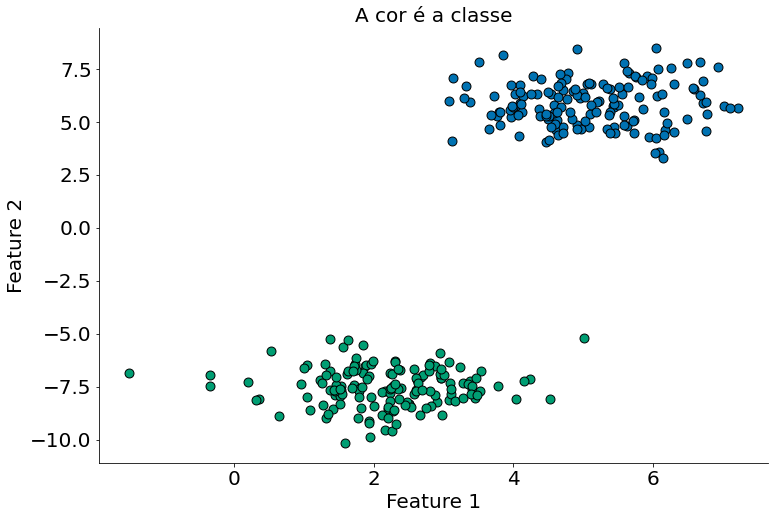

In [35]:
X, y = datasets.make_blobs(n_samples=300, centers=2, n_features=2)
ones = y == 1
plt.scatter(X[:, 0][ones], X[:, 1][ones], edgecolors='k', s=80)
plt.scatter(X[:, 0][~ones], X[:, 1][~ones], edgecolors='k', s=80)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('A cor é a classe')
despine()

In [36]:
X_train = X[:200]
X_test = X[200:]
y_train = y[:200]
y_test = y[200:]

theta = gd(X_train, y_train)

Iter 0; theta =  [1. 1.]
Iter 1; theta = [0.9997566  1.00043995]; cross_e = 0.007652822819902491
Iter 2; theta = [0.99951392 1.00087848]; cross_e = 0.007627583641511265
Iter 3; theta = [0.99927194 1.00131559]; cross_e = 0.007602504166230671
Iter 4; theta = [0.99903068 1.00175128]; cross_e = 0.0075775828984517455
Iter 5; theta = [0.99879011 1.00218558]; cross_e = 0.0075528183611804
Iter 6; theta = [0.99855024 1.00261849]; cross_e = 0.007528209095748006
Iter 7; theta = [0.99831107 1.00305002]; cross_e = 0.007503753661527224
Iter 8; theta = [0.99807259 1.00348017]; cross_e = 0.007479450635653276
Iter 9; theta = [0.99783479 1.00390895]; cross_e = 0.00745529861275029
Iter 10; theta = [0.99759768 1.00433638]; cross_e = 0.007431296204662699
Iter 11; theta = [0.99736125 1.00476246]; cross_e = 0.007407442040191645
Iter 12; theta = [0.99712549 1.0051872 ]; cross_e = 0.00738373476483618
Iter 13; theta = [0.9968904  1.00561061]; cross_e = 0.007360173040539183
Iter 14; theta = [0.99665597 1.0060327

In [37]:
y_pred = sigmoid(X_test, theta) > 0.5
(y_pred == y_test).mean()

1.0

## Para explorar

* O `scikit-learn` possui módulos tanto para [regressão logística](http://scikit-learn.org/stable/modules/linear_model.html#logistic-regression) quanto para um mundo de outros classificadores.